# AGNs Tutorial 1 - SDSS database: introduction & data access

In [57]:
#import the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from astropy.io import fits
from astropy.table import Table

## Q. 1
**Select all objects which have:**
- **class = galaxy or quasar**
- **$0.05 <= z <= 0.30$**
- **SNR>35 near H-$\beta$ line (in optical band)**
- **have $[OIII]~5007$, $H\beta~4863$ and $H\gamma~4341$ lines present in emission (EQW < 0)**
- **FWHM of H$\beta$ > 1000 km/s.**

**And for each selected spectrum, find:**
- **[OIII]/H$\beta$ flux ratio**
- **H$\beta$/H$\gamma$ flux ratio**
- **[OIII]/H$\gamma$ flux ratio**
- **EW of H$\beta$**
- **flux of H$\beta$**
- **redshift**
- **extinction correction E(B-V) of type SFD**

The FWHM is not a direct parameter in the SDSS database and must be calculated from $\sigma$. Following [1], FWHM is related to $\sigma$ through $\mathrm{FWHM}=\sigma\sqrt{8\ln{2}}=2.35482004503\sigma$ and for the FWHM of H$\beta$ (Balmer line), we need to use `sigma_balmer`.

We also have to make sure that the fluxes for H$\beta$ and H$\gamma$ are not zero, so that computing the flux ratios does not give a div/0 run-time error.

The following SQL query was submitted to the SDSS SQL search tool [2]:
```
SELECT
g.sigma_balmer*2.35482004503 AS H_FWHM,
(g.oiii_5007_flux/g.h_beta_flux) as o_iii_h_beta_flux_ratio,
(g.h_beta_flux/g.h_gamma_flux) as h_beta_h_gamma_flux_ratio,
(g.oiii_5007_flux/g.h_gamma_flux) as o_iii_h_gamma_flux_ratio,
g.h_beta_eqw, g.h_beta_flux, s.z as redshift, i.e_bv_sfd as reddening

FROM SpecObj AS s
JOIN GalSpecLine AS g ON s.specobjid=g.specobjid
JOIN GalSpecInfo AS i ON s.specobjid=i.specobjid

WHERE
    (s.class = 'QSO' OR s.class = 'GALAXY')
    AND s.z BETWEEN 0.05 AND 0.30
    AND s.snmedian_g > 35
    AND g.oiii_5007_eqw < 0
    AND g.h_beta_eqw < 0
    AND g.h_gamma_eqw < 0
    AND g.sigma_balmer*2.35482004503 > 1000
    AND g.h_beta_flux <> 0
    AND g.h_gamma_flux <> 0
```

and the resulting data is contained in the file _Skyserver_SQL_results.csv_, which is loaded and displayed below.

In [103]:
q1 = pd.read_csv('C:\\Users\\franc\\Desktop\\AGN\\Tutorial_1\\Skyserver_SQL_results.csv', header=1)
print(q1.to_markdown())

|     |   H_FWHM |   o_iii_h_beta_flux_ratio |   h_beta_h_gamma_flux_ratio |   o_iii_h_gamma_flux_ratio |   h_beta_eqw |   h_beta_flux |   redshift |   reddening | subclass            |
|----:|---------:|--------------------------:|----------------------------:|---------------------------:|-------------:|--------------:|-----------:|------------:|:--------------------|
|   0 |  1177.41 |                0.992605   |                   1.89851   |                 1.88447    | -12.1511     |   1786.94     |  0.0618372 |  0.0403699  | STARBURST BROADLINE |
|   1 |  1177.41 |                1.51933    |                   1.98169   |                 3.01083    |  -0.345229   |     34.036    |  0.0546334 |  0.0243895  | nan                 |
|   2 |  1177.41 |                0.59374    |                   1.28825   |                 0.764885   |  -0.283855   |     21.14     |  0.0537623 |  0.0208267  | nan                 |
|   3 |  1177.41 |                0.224671   |                   1.030

## Q.2

**How many objects have you found?**

**Which one from the conditions in `WHERE` is narrowing the results most severely?**

In [93]:
print(len(q1))
print(q1.iloc[0])

231
H_FWHM                                   1177.41
o_iii_h_beta_flux_ratio                 0.992605
h_beta_h_gamma_flux_ratio               1.898506
o_iii_h_gamma_flux_ratio                1.884467
h_beta_eqw                             -12.15111
h_beta_flux                             1786.943
redshift                                0.061837
reddening                                0.04037
subclass                     STARBURST BROADLINE
Name: 0, dtype: object


There are 231 objects.

To check which of the conditions is narrowing results the most, remove each condition and check the new number of objects without without this additional filter. The results are tabulated below.

| filter removed | new no. of obj |
|---|---|
|`class = 'QSO' or 'GALAXY'`| 231 |
|   `s.z BETWEEN 0.05 AND 0.30` | 1475 |
|    `s.snmedian_g > 35` |233|
|    `g.oiii_5007_eqw < 0` | 25779 |
|   `g.h_beta_eqw < 0` |234|
|   `g.h_gamma_eqw < 0` |247|
|    `g.sigma_balmer*2.35482004503 > 1000` |411|

As can be seen from the table, the condition `g.oiii_5007_eqw < 0`, which requires the [0III] line to be present, is the most retrictive, followed by the redshift constraint `s.z BETWEEN 0.05 AND 0.30`.

## Q.3

**Find out if there is some of the subclass AGN objects with the same conditions as in Q.1. Adapt your code to get the result.**

The code was adapted to display also the subclass of the object (by adding `i.subclass` under `SELECT`).

```
SELECT
g.sigma_balmer*2.35482004503 AS H_FWHM,
(g.oiii_5007_flux/g.h_beta_flux) as o_iii_h_beta_flux_ratio,
(g.h_beta_flux/g.h_gamma_flux) as h_beta_h_gamma_flux_ratio,
(g.oiii_5007_flux/g.h_gamma_flux) as o_iii_h_gamma_flux_ratio,
g.h_beta_eqw, g.h_beta_flux, s.z as redshift, i.e_bv_sfd as reddening,
i.subclass

FROM SpecObj AS s
JOIN GalSpecLine AS g ON s.specobjid=g.specobjid
JOIN GalSpecInfo AS i ON s.specobjid=i.specobjid

WHERE
    (s.class = 'QSO' OR s.class = 'GALAXY')
    AND s.z BETWEEN 0.05 AND 0.30
    AND s.snmedian_g > 35
    AND g.oiii_5007_eqw < 0
    AND g.h_beta_eqw < 0
    AND g.h_gamma_eqw < 0
    AND g.sigma_balmer*2.35482004503 > 1000
    AND g.h_beta_flux <> 0
    AND g.h_gamma_flux <> 0
```

In [114]:
broadline = q1[q1['subclass']=='BROADLINE']
print('No. of broadline AGN:', len(broadline))

sb_broad = q1[q1['subclass']=='STARBURST BROADLINE']
print('No. of starburst broadline AGN:', len(sb_broad))

sc = len(broadline)+len(sb_broad)
qty=sc/len(q1)*100
print('Broadline and starburst broadline AGNs make up {:.0f}% of our results.'.format(qty))

No. of broadline AGN: 72
No. of starburst broadline AGN: 70
Broadline and starburst broadline AGNs make up 61% of our results.


The conditions set in Q.1 seem to correspond to the 'broadline' or 'starburst broadline' AGN subclasses.

## Q.4
**Modify your solution in Q.1 to include objects with $0.05 <= z <= 0.60$.
Using this modified solution and the list of objects** _287-plate-mjd-fiber.txt_**, submit the SQL query via CrossID.**

The new SQL query including the wider redshift range is

```
SELECT s.plate, s.mjd, s.fiberid, s.z, i.subclass, i.e_bv_sfd, g.h_beta_flux, g.h_beta_eqw,
(g.oiii_5007_flux/g.h_beta_flux) as oiii_h_beta_flux_ratio, (g.oiii_5007_flux/g.h_gamma_flux) as oiii_h_gamma_flux_ratio, (g.h_beta_flux/g.h_gamma_flux) as h_beta_h_gamma_flux_ratio

FROM #upload u
      JOIN SpecObjAll AS s ON (s.plate=u.up_plate AND s.mjd=u.up_mjd AND s.fiberID=u.up_fiber)
JOIN GalSpecLine AS g ON s.specobjid=g.specobjid
JOIN GalSpecInfo AS i ON s.specobjid=i.specobjid

WHERE
(s.class = "QSO" OR s.class = "GALAXY")
    AND s.z BETWEEN 0.05 AND 0.60
    AND s.snmedian_g > 35
    AND g.oiii_5007_eqw < 0
    AND g.h_beta_eqw < 0
    AND g.h_gamma_eqw < 0
    AND g.sigma_balmer*2.35482004503 > 1000
    AND g.h_beta_flux <> 0
    AND g.h_gamma_flux <> 0
```

This query was submitted to the SDSS Cross-ID tool at [3], along with the data file _287-plate-mjd-fiber.txt_ and the following settings selected.

![spectra results](C:\Users\franc\Desktop\AGN\Tutorial_1\Cross_ID_SS.png)

The results obtained from the query are contained in _Skyserver_CrossID.csv_, and displayed below.

In [116]:
#loading the data to view
q4 = pd.read_csv('C:\\Users\\franc\\Desktop\\AGN\\Tutorial_1\\Skyserver_CrossID.csv')
q4

,,,,,,,,,,#Table1
plate,mjd,fiberid,z,subclass,e_bv_sfd,h_beta_flux,h_beta_eqw,oiii_h_beta_flux_ratio,oiii_h_gamma_flux_ratio,h_beta_h_gamma_flux_ratio
2173,53874,354,0.4557629,BROADLINE,0.05542863,509.9599,-11.65119,0.6451375,1.609646,2.495043
1843,53816,584,0.4980763,BROADLINE,0.01577194,557.34,-12.03965,0.4476209,1.072644,2.396323
640,52178,513,0.4174148,BROADLINE,0.09496573,952.4866,-10.36639,0.3341854,0.5882106,1.760133
637,52174,259,0.5993487,BROADLINE,0.07477354,3992.194,-11.40223,0.2523734,0.5993569,2.374881
1844,54138,112,0.5256413,BROADLINE,0.02177914,717.105,-6.350803,0.5879771,1.071625,1.822562
402,51793,479,0.5524943,BROADLINE,0.03973217,1318.962,-11.35889,0.307347,0.7138805,2.322718
1791,54266,46,0.4389866,BROADLINE,0.02399247,1027.594,-17.74196,0.3758007,0.8569891,2.280435
1716,53827,350,0.5008188,BROADLINE,0.03326718,798.7177,-9.304626,0.9021373,1.71744,1.903746
2347,53757,151,0.5113347,BROADLINE,0.02648882,1452.441,-16.70732,0.6893487,1.492386,2.164921


## Q.5
**Check the spectra of found objects, download some of them using wget.**

The spectral data of the objects found using CrossID are requested using the SDSS Science Archive Server (SAS) Spectrum Search tool [4]. The `wget` urls for downloading this data are collected in _download_url_spectra.txt_.

The first 5 spectra from the results shown below were downloaded as _.fits_ files.

![spectra results](C:\Users\franc\Desktop\AGN\Tutorial_1\spectra-results-first5.png)

## Q.6

**Read downloaded _.fits_ files and plot the spectra using Python.**

In [120]:
#information about the 5 spectra
files = ['spec-0268-51633-0235.fits', 'spec-0402-51793-0479.fits', 'spec-0411-51817-0381.fits', 'spec-0408-51821-0611.fits', 'spec-0329-52056-0577.fits']
plate = [268, 402, 411, 408, 329]
mjd = [51633, 51793, 51817, 51821, 52056]
fiber = [235, 479, 381, 611, 577]

In [121]:
#for 1 FITS file
plot = fits.open('C:\\Users\\franc\\Desktop\\AGN\\Tutorial_1\\'+str(files[0]), memmap=True)

In [122]:
plot[1].columns

ColDefs(
    name = 'flux'; format = 'E'
    name = 'loglam'; format = 'E'
    name = 'ivar'; format = 'E'
    name = 'and_mask'; format = 'J'
    name = 'or_mask'; format = 'J'
    name = 'wdisp'; format = 'E'
    name = 'sky'; format = 'E'
    name = 'model'; format = 'E'
)

In [17]:
Table(plot[1].data)

flux,loglam,ivar,and_mask,or_mask,wdisp,sky,model
float32,float32,float32,int32,int32,float32,float32,float32
118.85568,3.58,0.025620818,0,0,1.3487778,10.223456,116.23333
115.65326,3.5801,0.028720735,0,0,1.3482839,9.897737,115.39884
106.71307,3.5802,0.031155253,0,0,1.3477901,9.624965,115.2619
107.15258,3.5803,0.031942006,0,0,1.3472986,9.3489895,113.99698
105.32813,3.5804,0.032686844,0,0,1.3468072,9.063609,112.87552
108.93706,3.5805,0.03226811,0,0,1.3463138,8.771913,113.042656
114.73749,3.5806,0.030308573,0,0,1.3458194,8.555886,113.77588
118.03412,3.5807,0.02972555,0,0,1.34533,8.358921,114.38368
122.39366,3.5808,0.02850162,0,0,1.3448355,8.200877,114.99597


In [123]:
#setting plot parameters
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

Text(0.5, 1.0, 'Object at: plate 268, MJD 51633, fiber ID 235')

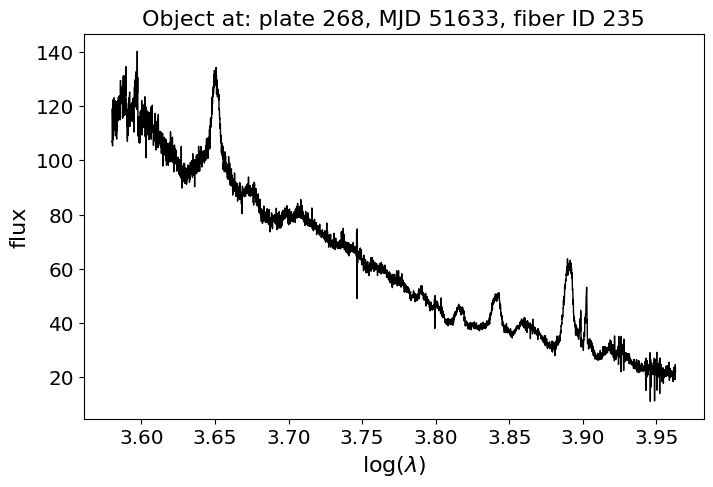

In [126]:
#plot the spectrum
fig=plt.figure(figsize=(8, 5))
plt.plot(plot[1].data['loglam'], plot[1].data['flux'], linewidth=1, c='black')
plt.xlabel(r'log($\lambda$)', fontsize = 16)
plt.ylabel('flux', fontsize = 16)
plt.title('Object at: plate '+str(plate[0])+', MJD '+str(mjd[0])+', fiber ID '+str(fiber[0]), fontsize = 16)

spec-0268-51633-0235.fits
spec-0402-51793-0479.fits
spec-0411-51817-0381.fits
spec-0408-51821-0611.fits
spec-0329-52056-0577.fits


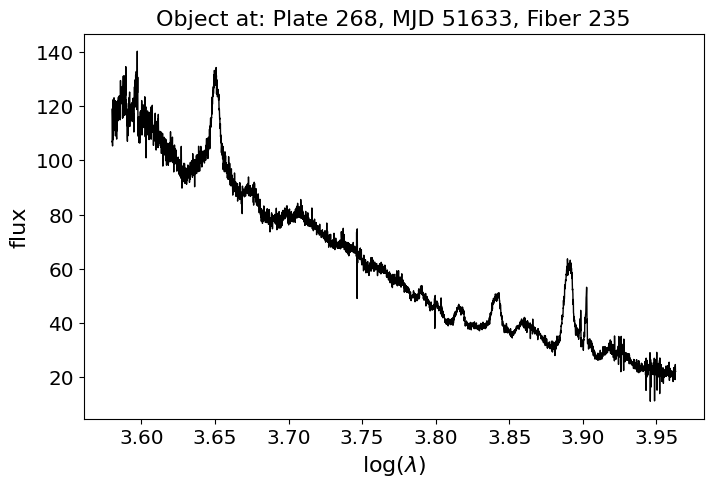

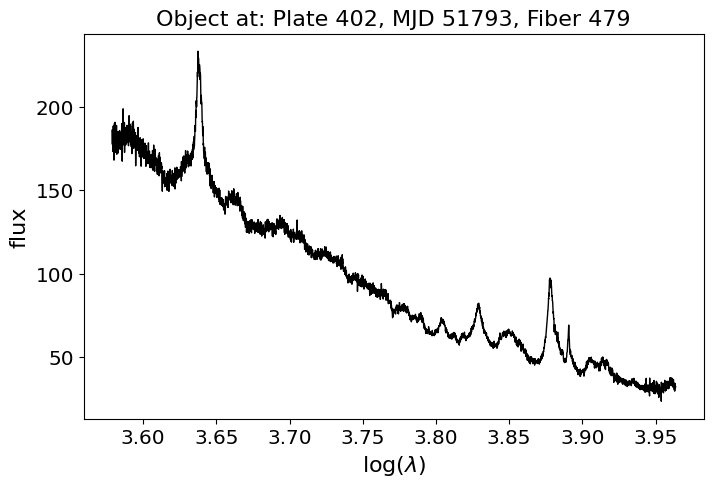

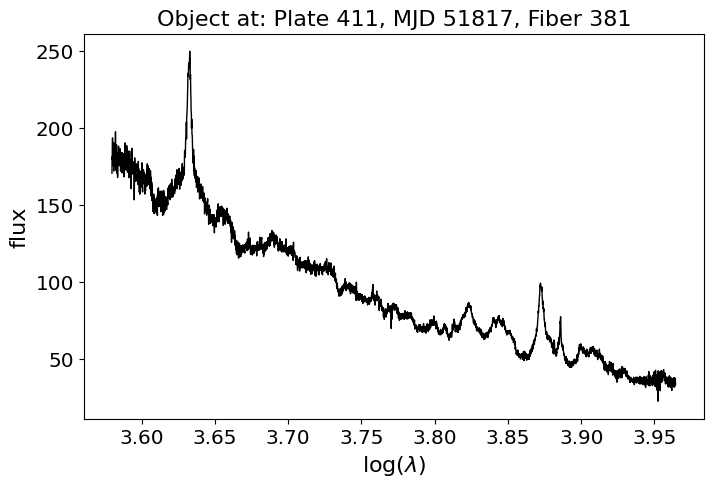

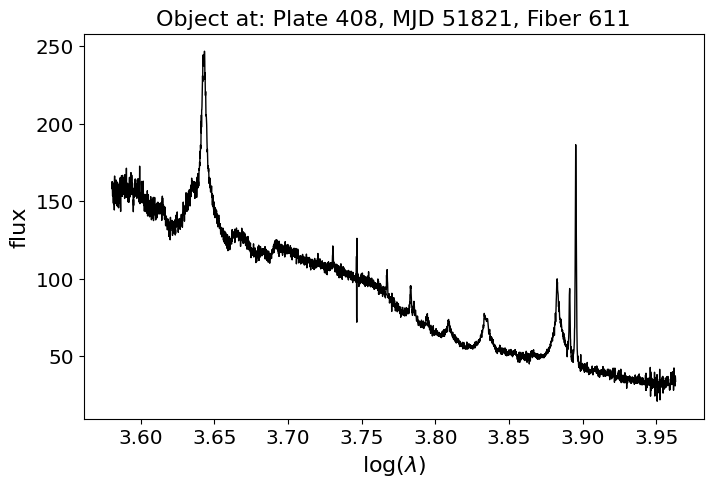

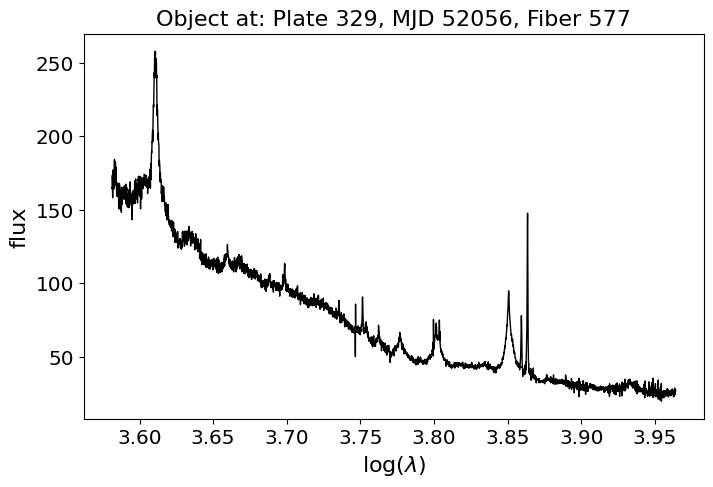

In [132]:
#plotting all spectra using for loop

for i in range(0,len(files)):
    #print name of file to check loop progression
    print(files[i])

    #create plot
    plot = fits.open('C:\\Users\\franc\\Desktop\\AGN\\Tutorial_1\\'+str(files[i]), memmap=True)
    fig=plt.figure(figsize=(8, 5))
    plt.plot(plot[1].data['loglam'], plot[1].data['flux'], linewidth=1, c='black')
    plt.xlabel(r'log($\lambda$)', fontsize = 16)
    plt.ylabel('flux', fontsize = 16)
    plt.title('Object at: Plate '+str(plate[i])+', MJD '+str(mjd[i])+', Fiber '+str(fiber[i]), fontsize = 16)

    #save the figure
    plt.savefig('C:\\Users\\franc\\Desktop\\AGN\\Tutorial_1\\obj_plate_'+str(plate[i])+'_mjd_'+str(mjd[i])+'_fiber_'+str(fiber[i]))

    #iterate counter
    i = i + 1

## References

[1] https://brainder.org/2011/08/20/gaussian-kernels-convert-fwhm-to-sigma/

[2] https://skyserver.sdss.org/dr18/SearchTools/sql

[3] https://skyserver.sdss.org/dr18/en/tools/crossid/crossid.aspx

[4] https://dr18.sdss.org/optical/spectrum/search